# SUPERVISED MACHINE LEARNING: MODELOS LOGÍSTICOS BINÁRIOS E MULTINOMIAIS

UNIVERSIDADE DE SÃO PAULO

MBA DATA SCIENCE & ANALYTICS USP/ESALQ

Prof. Dr. Luiz Paulo Fávero

In [2]:
# Instalação dos pacotes.

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests

In [3]:
# Importação dos pacotes.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy import stats 
import plotly.graph_objects as go
from statsmodels.iolib.summary2 import summary_col
from statsmodels.discrete.discrete_model import MNLogit
from math import exp
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

## CURVA SIGMOIDE

In [4]:
# Estabelecendo uma função para a probabilidade de ocorrência de um evento.
def prob(z):
    return 1 / (1 + exp(-z))

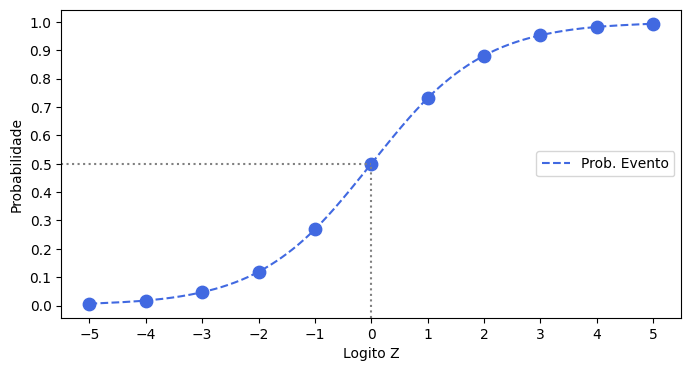

In [5]:
# Plotando a curva sigmoide teórica de ocorrência de um evento para um range do logito z entre -5 e +5.

logitos = []
probs = []

for i in np.arange(-5, 6):
    logitos.append(i)
    probs.append(prob(i))
    
df = pd.DataFrame({'logito': logitos, 'probs': probs})

# Interpolação spline (smooth probability line).
spline = UnivariateSpline(df['logito'], df['probs'], s=0)

logitos_smooth = np.linspace(df['logito'].min(), df['logito'].max(), 500)
probs_smooth = spline(logitos_smooth)

plt.figure(figsize=(8,4))
plt.plot(logitos_smooth, probs_smooth, color='royalblue',
         linestyle='--', label='Prob. Evento')
plt.scatter(df['logito'], df['probs'], color='royalblue', marker='o', s=80)
plt.axhline(y = df.probs.mean(), color = 'grey', linestyle = ':', xmax = .5)
plt.axvline(x = 0, color = 'grey', linestyle=':', ymax = 0.5)
plt.xlabel("Logito Z", fontsize=10)
plt.ylabel("Probabilidade", fontsize=10)
plt.xticks(np.arange(-5, 6), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)
plt.legend(fontsize=10, loc='center right')
plt.show()

## REGRESSÃO LOGÍSTICA BINÁRIA

In [6]:
# Carregamento da base de dados.
url = 'https://raw.githubusercontent.com/filipecarbonera/MBA_USP_Data_Science_Analytics/refs/heads/main/5.%20Modelos%20Log%C3%ADsticos%20Bin%C3%A1rios%20e%20Multinomiais/Dados/atrasado.csv'

df_atrasado = pd.read_csv(url,delimiter=',')
df_atrasado.head()

,estudante,atrasado,dist,sem
0,Gabriela,0,12.5,7
1,Patricia,0,13.3,10
2,Gustavo,0,13.4,8
3,Leticia,0,23.5,7
4,Luiz Ovidio,0,9.5,8


In [7]:
# Características das variáveis do dataset.
df_atrasado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    int64  
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [8]:
# Estatísticas univariadas.
df_atrasado.describe()

,atrasado,dist,sem
count,100.000000,100.000000,100.000000
mean,0.590000,14.073000,10.210000
std,0.494311,4.330112,1.578229
min,0.000000,1.000000,5.000000
25%,0.000000,12.000000,10.000000
50%,1.000000,13.350000,10.000000
75%,1.000000,16.125000,10.000000
max,1.000000,29.000000,18.000000


In [9]:
# Tabela de frequências absolutas da variável 'atrasado'.
df_atrasado['atrasado'].value_counts().sort_index()

atrasado
0    41
1    59
Name: count, dtype: int64

In [10]:
# Estimação de um modelo logístico binário pela função 'smf.glm' ('statsmodels.formula.api').
modelo_atrasos = smf.glm(formula='atrasado ~ dist + sem', data=df_atrasado, family=sm.families.Binomial()).fit()

# Parâmetros do 'modelo_atrasos'.
modelo_atrasos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               atrasado   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.466
Date:                Tue, 29 Oct 2024   Deviance:                       100.93
Time:                        20:57:30   Pearson chi2:                     86.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2913
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.1665      8.442     -3.100      0.002     -42.712      -9.621
dist           0.1904      0.076      2.493      0.013       0.041       0.340
sem            2.3629      0.795      2.972      0.003       0.804       3.921
==============================================================================
"""

In [11]:
# Outputs do modelo pela função 'summary_col'.

summary_col([modelo_atrasos], model_names=["MODELO"], stars=True, info_dict = { 'N':lambda x: "{0:d}".format(int(x.nobs)),
                                                                               'Log-lik':lambda x: "{:.3f}".format(x.llf)})

,MODELO
Intercept,-26.1665***
,(8.4420)
dist,0.1904**
,(0.0764)
sem,2.3629***
,(0.7951)
N,100
Log-lik,-50.466


In [12]:
# Fazendo predições para o 'modelo_atrasos'.
# Exemplo: qual a probabilidade média de se chegar atrasado quando o trajeto tem 7 km e passa-se por 10 semáforos no percurso?
modelo_atrasos.predict(pd.DataFrame({'dist':[7], 'sem':[10]}))

0    0.230566
dtype: float64

In [13]:
# Adicionando os valores previstos de probabilidade na base de dados.
df_atrasado['phat'] = modelo_atrasos.predict()
df_atrasado.head()

,estudante,atrasado,dist,sem,phat
0,Gabriela,0,12.5,7,0.000712
1,Patricia,0,13.3,10,0.498561
2,Gustavo,0,13.4,8,0.008903
3,Leticia,0,23.5,7,0.005751
4,Luiz Ovidio,0,9.5,8,0.004257


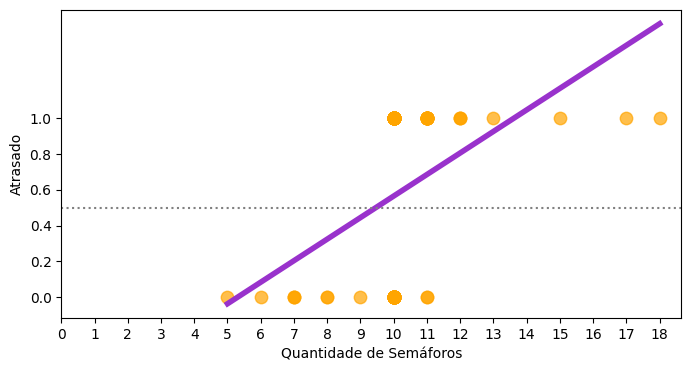

In [14]:
# Gráficos com ajustes entre a variável dependente e a variável 'sem'.
# Ajuste linear entre a variável dependente e a variável 'sem' (Gráfico errado: apenas para fins didáticos).

plt.figure(figsize=(8,4))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'], ci=None, marker='o', scatter_kws={'color':'orange', 's':80, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':4})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=10)
plt.ylabel('Atrasado', fontsize=10)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

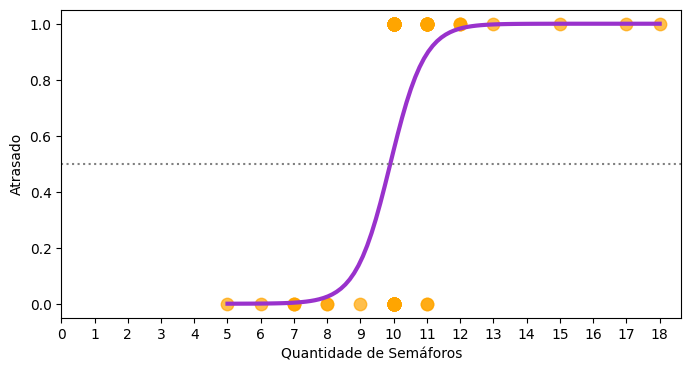

In [15]:
# Ajuste logístico determinístico entre a variável dependente e a variável 'sem'.
# Sigmoide.

plt.figure(figsize=(8,4))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'], ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':80, 'alpha':0.7}, line_kws={'color':'darkorchid', 'linewidth':3})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=10)
plt.ylabel('Atrasado', fontsize=10)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

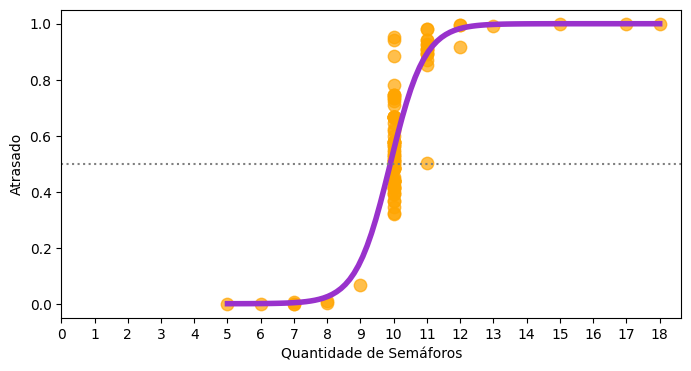

In [16]:
# Ajuste logístico probabilístico entre a variável dependente e a variável 'sem'.
# Sigmoide.

plt.figure(figsize=(8,4))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['phat'], ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':80, 'alpha':0.7}, line_kws={'color':'darkorchid', 'linewidth':4})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=10)
plt.ylabel('Atrasado', fontsize=10)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

In [17]:
# Construção de função para a definição da matriz de confusão.
def matriz_confusao(predicts, observado, cutoff):

    values = predicts.values
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
    
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    # Visualização dos principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

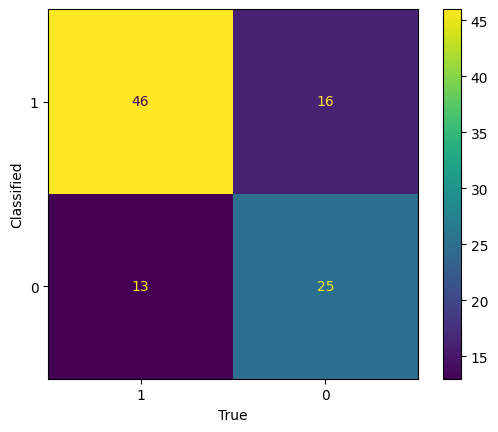

,Sensitividade,Especificidade,Acurácia
0,0.779661,0.609756,0.71


In [18]:
# Matriz de confusão para cutoff = 0.5.
matriz_confusao(observado=df_atrasado['atrasado'], predicts=df_atrasado['phat'], cutoff=0.5)

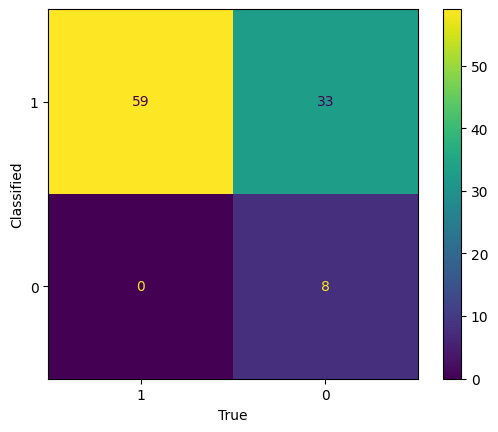

,Sensitividade,Especificidade,Acurácia
0,1.0,0.195122,0.67


In [19]:
# Matriz de confusão para cutoff = 0.3.
matriz_confusao(observado=df_atrasado['atrasado'], predicts=df_atrasado['phat'], cutoff=0.3)

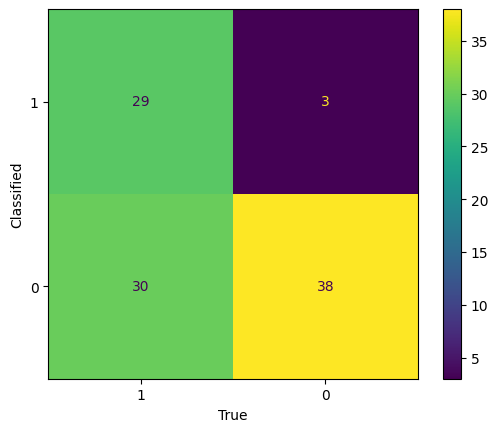

,Sensitividade,Especificidade,Acurácia
0,0.491525,0.926829,0.67


In [20]:
# Matriz de confusão para cutoff = 0.7.
matriz_confusao(observado=df_atrasado['atrasado'], predicts=df_atrasado['phat'], cutoff=0.7)

**Igualando critérios de especificidade e de sensitividade**

Tentaremos estabelecer um critério que iguale a probabilidade de acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de acerto daqueles que não chegarão atrasados (especificidade).

**ATENÇÃO:** o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA FORMA, o procedimento garante a maximização da acurácia do modelo!

In [21]:
# Criação da função 'espec_sens' para a construção de um dataset com diferentes valores de cutoff, sensitividade e especificidade:
def espec_sens(observado,predicts):
    
    # Adicionar objeto com os valores dos predicts.
    values = predicts.values
    
    # Range dos cutoffs a serem analisados em steps de 0.01.
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade.
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:

        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict.
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff.
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas.
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs.
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [22]:
# Até o momento, foram extraídos 3 vetores: 'sensitividade', 'especificidade' e 'cutoffs'.
# Assim, criamos um dataframe que contém os vetores mencionados (dataframe 'dados_plotagem').

dados_plotagem = espec_sens(observado = df_atrasado['atrasado'], predicts = df_atrasado['phat'])
dados_plotagem.head()

,cutoffs,sensitividade,especificidade
0,0.00,1.0,0.000000
1,0.01,1.0,0.170732
2,0.02,1.0,0.170732
3,0.03,1.0,0.170732
4,0.04,1.0,0.170732


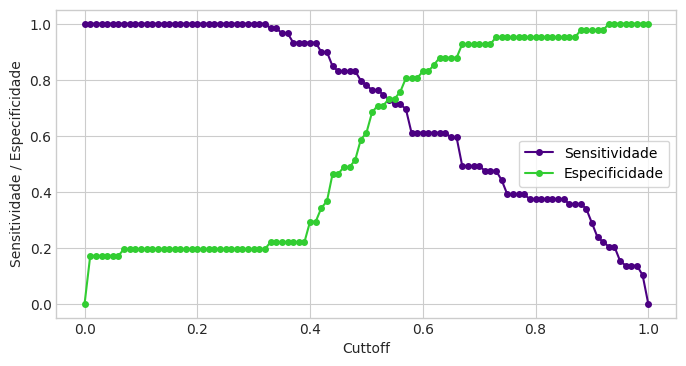

In [23]:
# In[1.13]: Plotagem de um gráfico que mostra a variação da especificidade e da sensitividade em função do cutoff.

plt.figure(figsize=(8,4))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o', color='indigo', markersize=4)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o', color='limegreen', markersize=4)
plt.xlabel('Cuttoff', fontsize=10)
plt.ylabel('Sensitividade / Especificidade', fontsize=10)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=10)
plt.show()

In [24]:
# In[1.14]: Construção da curva ROC
fpr, tpr, thresholds =roc_curve(df_atrasado['atrasado'], df_atrasado['phat'])
roc_auc = auc(fpr, tpr)
roc_auc


0.79888383629599

In [25]:
# Cálculo do coeficiente de GINI.
gini = (roc_auc - 0.5)/(0.5)
gini

0.59776767259198

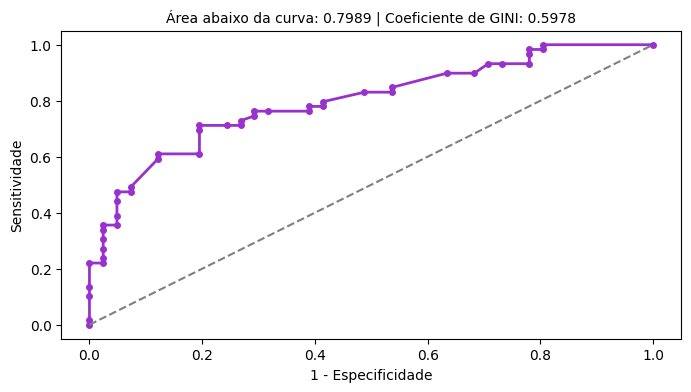

In [26]:
# Plotando a curva ROC.
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=4, linewidth=2)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) + ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=10)
plt.xlabel('1 - Especificidade', fontsize=10)
plt.ylabel('Sensitividade', fontsize=10)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

## REGRESSÃO LOGÍSTICA BINÁRIA E PROCEDIMENTO STEPWISE

In [27]:
url = 'https://raw.githubusercontent.com/filipecarbonera/MBA_USP_Data_Science_Analytics/refs/heads/main/5.%20Modelos%20Log%C3%ADsticos%20Bin%C3%A1rios%20e%20Multinomiais/Dados/challenger.csv'

df_challenger = pd.read_csv(url,delimiter=',')
df_challenger.head()

,desgaste,temperatura,pressao,t
0,0,66,50,1
1,1,70,50,2
2,0,69,50,3
3,0,68,50,4
4,0,67,50,5


In [28]:
# Características das variáveis do dataset.
df_challenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressao      23 non-null     int64
 3   t            23 non-null     int64
dtypes: int64(4)
memory usage: 864.0 bytes


In [29]:
# Estatísticas univariadas.
df_challenger.describe()

,desgaste,temperatura,pressao,t
count,23.000000,23.000000,23.000000,23.00000
mean,0.304348,69.565217,152.173913,12.00000
std,0.558796,7.057080,68.221332,6.78233
min,0.000000,53.000000,50.000000,1.00000
25%,0.000000,67.000000,75.000000,6.50000
50%,0.000000,70.000000,200.000000,12.00000
75%,0.500000,75.000000,200.000000,17.50000
max,2.000000,81.000000,200.000000,23.00000


- **desgaste:** quantidade de vezes em que ocorreu stress térmico
- **temperatura:** temperatura de lançamento (graus ºF)
- **pressão:** pressão de verificação de vazamento (psi: libra-força por polegada ao quadrado)
- **t:** teste para o lançamento (id)

In [30]:
# Criação da variável dependente binária 'falha'.

# Não há uma variável binária para servir como uma variável dependente, certo?
# Então vamos criá-la, considerando a ocorrência de desgastes de peças como a ocorrência de um evento que chamaremos de 'falha':
df_challenger.loc[df_challenger['desgaste'] != 0 , 'falha'] = 1
df_challenger.loc[df_challenger['desgaste'] == 0, 'falha'] = 0

In [31]:
# Transformando a variável 'falha' para o tipo 'int' (poderia também deixar como 'float').
# A fim de que seja possível estimar o modelo por meio da função 'sm.Logit.from_formula'.
df_challenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   desgaste     23 non-null     int64  
 1   temperatura  23 non-null     int64  
 2   pressao      23 non-null     int64  
 3   t            23 non-null     int64  
 4   falha        23 non-null     float64
dtypes: float64(1), int64(4)
memory usage: 1.0 KB


In [32]:
df_challenger['falha'] = df_challenger['falha'].astype('int64')
df_challenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressao      23 non-null     int64
 3   t            23 non-null     int64
 4   falha        23 non-null     int64
dtypes: int64(5)
memory usage: 1.0 KB


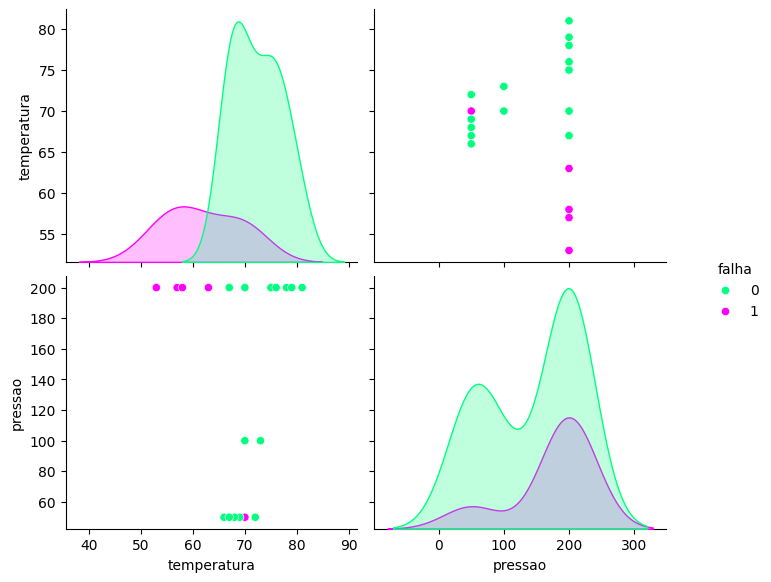

In [33]:
# Gráfico 'pairplot' com scatters e KDEs por 'falha'.
cores_desejadas = {0: 'springgreen', 1: 'magenta'}

g = sns.pairplot(df_challenger[['falha','temperatura','pressao']], hue='falha', palette=cores_desejadas)
g.fig.set_size_inches(8, 6)
plt.show()

In [35]:
# Estimação do modelo logístico binário pela função 'sm.Logit.from_formula' ('statsmodels.api').
# O modelo a seguir também pode ser estimado por meio da função 'smf.glm' ('statsmodels.formula.api').
modelo_challenger = sm.Logit.from_formula('falha ~ temperatura + pressao', df_challenger).fit()

# Parâmetros do 'modelo_challenger'.
modelo_challenger.summary()

Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            2
Date:                Tue, 29 Oct 2024   Pseudo R-squ.:                  0.4685
Time:                        20:57:46   Log-Likelihood:                -7.0164
converged:                       True   LL-Null:                       -13.201
Covariance Type:            nonrobust   LLR p-value:                  0.002061
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      21.8436     11.936      1.830      0.067      -1.551      45.239
temperatura    -0.3501      0.173     -2.024      0.043      -0.689      -0.011
pressao         0.0060      0.010      0.616      0.538      -0.013       0.025
===============================================================================
"""

## Procedimento Stepwise

In [37]:
# Estimação do modelo por meio do procedimento Stepwise
step_challenger = stepwise(modelo_challenger, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 falha ~ Q('temperatura') + Q('pressao')
Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8

 Discarding atribute "Q('pressao')" with p-value equal to 0.5378022290437207 

Estimating model...: 
 falha ~ Q('temperatura')
Optimization terminated successfully.
         Current function value: 0.313604
         Iterations 8

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('pressao')", 'p-value': 0.5378022290437207}

 Model after stepwise process...: 
 falha ~ Q('temperatura') 

                           Logit Regression Results                           
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Oct 2024   Pseudo 

**Fazendo predições para o modelo 'step_challenger':**

In [38]:
# Exemplo 1: qual a probabilidade média de falha a 70ºF (~21.11ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[70]}))

0    0.130777
dtype: float64

In [39]:
# Exemplo 2: qual a probabilidade média de falha a 77ºF (25ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[77]}))

0    0.011419
dtype: float64

In [40]:
# Exemplo 3: qual a probabilidade média de falha a 34ºF (~1.11ºC)? (Temperatura no momento do lançamento)
step_challenger.predict(pd.DataFrame({'temperatura':[34]}))

0    0.999988
dtype: float64

In [41]:
# Atribuindo uma coluna no dataframe para os resultados.
df_challenger['phat'] = step_challenger.predict()
df_challenger.head()

,desgaste,temperatura,pressao,t,falha,phat
0,0,66,50,1,0,0.394770
1,1,70,50,2,1,0.130777
2,0,69,50,3,0,0.178373
3,0,68,50,4,0,0.238539
4,0,67,50,5,0,0.311309


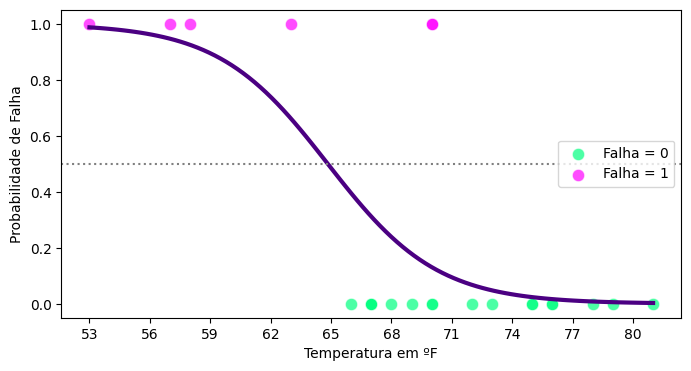

In [45]:
# Construção da sigmoide.
# Probabilidade de evento em função da variável 'temperatura'.

plt.figure(figsize=(8,4))
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 0], y=df_challenger['falha'][df_challenger['falha'] == 0],
                color='springgreen', alpha=0.7, s=80, label='Falha = 0')

sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 1], y=df_challenger['falha'][df_challenger['falha'] == 1],
                color='magenta', alpha=0.7, s=80, label='Falha = 1')

sns.regplot(x=df_challenger['temperatura'], y=df_challenger['falha'], logistic=True, ci=None, scatter=False,
            line_kws={'color': 'indigo', 'linewidth': 3})

plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Temperatura em ºF', fontsize=10)
plt.ylabel('Probabilidade de Falha', fontsize=10)
plt.xticks(np.arange(df_challenger['temperatura'].min(), df_challenger['temperatura'].max() + 0.01, 3), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.legend(fontsize=10, loc='center right')
plt.show()

# REGRESSÃO LOGÍSTICA BINÁRIA COM VARIÁVEIS EXPLICATIVAS QUANTI E QUALIS

In [46]:
# Carregamento da base de dados.
url = 'https://raw.githubusercontent.com/filipecarbonera/MBA_USP_Data_Science_Analytics/refs/heads/main/5.%20Modelos%20Log%C3%ADsticos%20Bin%C3%A1rios%20e%20Multinomiais/Dados/dados_fidelidade.csv'

df_fidelidade = pd.read_csv(url, delimiter=',')
df_fidelidade.head()

,id,fidelidade,sexo,idade,atendimento,sortimento,acessibilidade,preço
0,1,nao,feminino,34,2,2,1,1
1,2,nao,feminino,34,2,2,1,1
2,3,nao,masculino,34,3,2,4,2
3,4,nao,feminino,34,4,3,3,3
4,5,nao,feminino,34,4,3,1,4


In [47]:
# Características das variáveis do dataset.
df_fidelidade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3000 non-null   int64 
 1   fidelidade      3000 non-null   object
 2   sexo            3000 non-null   object
 3   idade           3000 non-null   int64 
 4   atendimento     3000 non-null   int64 
 5   sortimento      3000 non-null   int64 
 6   acessibilidade  3000 non-null   int64 
 7   preço           3000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 187.6+ KB


In [48]:
# Estatísticas univariadas.
df_fidelidade.describe()

,id,idade,atendimento,sortimento,acessibilidade,preço
count,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,34.21000,3.490000,3.360000,3.330000,3.380000
std,866.169729,1.57058,0.964474,1.221023,1.296789,1.017814
min,1.000000,29.00000,1.000000,1.000000,1.000000,1.000000
25%,750.750000,34.00000,3.000000,2.750000,3.000000,3.000000
50%,1500.500000,34.00000,4.000000,4.000000,3.000000,3.000000
75%,2250.250000,34.00000,4.000000,4.000000,5.000000,4.000000
max,3000.000000,42.00000,5.000000,5.000000,5.000000,5.000000


In [49]:
# Alteração dos tipos das variáveis não quantitativas no dataframe.
df_fidelidade['id'] = df_fidelidade['id'].astype('str')
df_fidelidade['atendimento'] = df_fidelidade['atendimento'].astype('object')
df_fidelidade['sortimento'] = df_fidelidade['sortimento'].astype('object')
df_fidelidade['acessibilidade'] = df_fidelidade['acessibilidade'].astype('object')
df_fidelidade['preço'] = df_fidelidade['preço'].astype('object')

# Características das variáveis do dataset.
df_fidelidade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3000 non-null   object
 1   fidelidade      3000 non-null   object
 2   sexo            3000 non-null   object
 3   idade           3000 non-null   int64 
 4   atendimento     3000 non-null   object
 5   sortimento      3000 non-null   object
 6   acessibilidade  3000 non-null   object
 7   preço           3000 non-null   object
dtypes: int64(1), object(7)
memory usage: 187.6+ KB


In [51]:
# Estatísticas univariadas.
df_fidelidade.describe()

,idade
count,3000.00000
mean,34.21000
std,1.57058
min,29.00000
25%,34.00000
50%,34.00000
75%,34.00000
max,42.00000


In [53]:
# Note que a variável Y 'fidelidade' está definida como objeto (PROBLEMA!!!).

# Transformando a variável Y para 0 e 1 e para o tipo 'int' (poderia também ser do tipo 'float').
# A fim de que seja possível estimar o modelo por meio da função 'sm.Logit.from_formula'.

df_fidelidade.loc[df_fidelidade['fidelidade']=='sim', 'fidelidade'] = 1
df_fidelidade.loc[df_fidelidade['fidelidade']=='nao', 'fidelidade'] = 0

df_fidelidade['fidelidade'] = df_fidelidade['fidelidade'].astype('int64')

df_fidelidade.head()


,id,fidelidade,sexo,idade,atendimento,sortimento,acessibilidade,preço
0,1,0,feminino,34,2,2,1,1
1,2,0,feminino,34,2,2,1,1
2,3,0,masculino,34,3,2,4,2
3,4,0,feminino,34,4,3,3,3
4,5,0,feminino,34,4,3,1,4


In [55]:
# Dummizando as variáveis 'atendimento', 'sortimento', 'acessibilidade', 'preço' e 'sexo'. O código abaixo, automaticamente, fará:
# a) a dummização das variáveis originais;
# b) a remoção das variáveis dummizadas originais;
# c) a definição das categorias de label 1 de cada variável original como categorias de referência, por meio do argumento 'drop_first=True'.

df_fidelidade_dummies = pd.get_dummies(df_fidelidade, columns=['atendimento', 'sortimento', 'acessibilidade', 'preço', 'sexo'],
    dtype=int, drop_first=True)

df_fidelidade_dummies.head()

,id,fidelidade,idade,atendimento_2,atendimento_3,atendimento_4,atendimento_5,sortimento_2,sortimento_3,sortimento_4,sortimento_5,acessibilidade_2,acessibilidade_3,acessibilidade_4,acessibilidade_5,preço_2,preço_3,preço_4,preço_5,sexo_masculino
0,1,0,34,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,34,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,34,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
3,4,0,34,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,5,0,34,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [56]:
# Estimação do modelo logístico binário.
lista_colunas = list(df_fidelidade_dummies.drop(columns=['id', 'fidelidade']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "fidelidade ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

# Modelo propriamente dito.
modelo_fidelidade = sm.Logit.from_formula(formula_dummies_modelo, df_fidelidade_dummies).fit()

# Parâmetros do 'modelo_fidelidade'.
modelo_fidelidade.summary()

Fórmula utilizada:  fidelidade ~ idade + atendimento_2 + atendimento_3 + atendimento_4 + atendimento_5 + sortimento_2 + sortimento_3 + sortimento_4 + sortimento_5 + acessibilidade_2 + acessibilidade_3 + acessibilidade_4 + acessibilidade_5 + preço_2 + preço_3 + preço_4 + preço_5 + sexo_masculino
Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             fidelidade   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2981
Method:                           MLE   Df Model:                           18
Date:                Tue, 29 Oct 2024   Pseudo R-squ.:                  0.6241
Time:                        21:08:00   Log-Likelihood:                -773.57
converged:                       True   LL-Null:                       -2057.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -68.9866      6.055    -11.394      0.000     -80.854     -57.120
idade                1.6870      0.176      9.561      0.000       1.341       2.033
atendimento_2        1.6808      0.336      5.004      0.000       1.023       2.339
atendimento_3        1.8172      0.342      5.321      0.000       1.148       2.487
atendimento_4        3.3168      0.311     10.651      0.000       2.706       3.927
atendimento_5        4.3119      0.432      9.977      0.000       3.465       5.159
sortimento_2         1.8503      0.396      4.671      0.000       1.074       2.627
sortimento_3         2.0511      0.321      6.389      0.000       1.422       2.680
sortimento_4         3.3290      0.320     10.388      0.000       2.701       3.957
sortimento_5         5.9365      0.402     14.755      0.000       5.148       6.725
acessibilidade_2     2.3475      0.446      5.258      0.000       1.473       3.223
acessibilidade_3     2.9229      0.281     10.404      0.000       2.372       3.474
acessibilidade_4     4.2907      2.123      2.021      0.043       0.130       8.451
acessibilidade_5     5.3662      0.376     14.260      0.000       4.629       6.104
preço_2              0.5706      2.122      0.269      0.788      -3.589       4.730
preço_3              2.9216      0.390      7.486      0.000       2.157       3.687
preço_4              3.0393      0.416      7.314      0.000       2.225       3.854
preço_5              3.9142      0.442      8.849      0.000       3.047       4.781
sexo_masculino       1.7695      0.197      8.962      0.000       1.383       2.157
====================================================================================
"""

### Procedimento Stepwise

In [58]:
#Estimação do modelo por meio do procedimento Stepwise.
step_modelo_fidelidade = stepwise(modelo_fidelidade, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 fidelidade ~ Q('idade') + Q('atendimento_2') + Q('atendimento_3') + Q('atendimento_4') + Q('atendimento_5') + Q('sortimento_2') + Q('sortimento_3') + Q('sortimento_4') + Q('sortimento_5') + Q('acessibilidade_2') + Q('acessibilidade_3') + Q('acessibilidade_4') + Q('acessibilidade_5') + Q('preço_2') + Q('preço_3') + Q('preço_4') + Q('preço_5') + Q('sexo_masculino')
Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9

 Discarding atribute "Q('preço_2')" with p-value equal to 0.7880570577805084 

Estimating model...: 
 fidelidade ~ Q('idade') + Q('atendimento_2') + Q('atendimento_3') + Q('atendimento_4') + Q('atendimento_5') + Q('sortimento_2') + Q('sortimento_3') + Q('sortimento_4') + Q('sortimento_5') + Q('acessibilidade_2') + Q('acessibilidade_3') + Q('acessibilidade_4') + Q('acessibilidade_5') + Q('preço_3') + Q('preço_4') + Q('preço_5') + Q('sexo_masculino')
Optimization terminated succes

In [59]:
# Construção de função para a definição da matriz de confusão.
def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade], 'Especificidade':[especificidade], 'Acurácia':[acuracia]})
    return indicadores

In [61]:
# Adicionando os valores previstos de probabilidade na base de dados.
df_fidelidade_dummies['phat'] = step_modelo_fidelidade.predict()
df_fidelidade_dummies.head()

,id,fidelidade,idade,atendimento_2,atendimento_3,atendimento_4,atendimento_5,sortimento_2,sortimento_3,sortimento_4,...,acessibilidade_2,acessibilidade_3,acessibilidade_4,acessibilidade_5,preço_2,preço_3,preço_4,preço_5,sexo_masculino,phat
0,1,0,34,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.000307
1,2,0,34,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.000307
2,3,0,34,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0.208086
3,4,0,34,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0.398124
4,5,0,34,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.038641


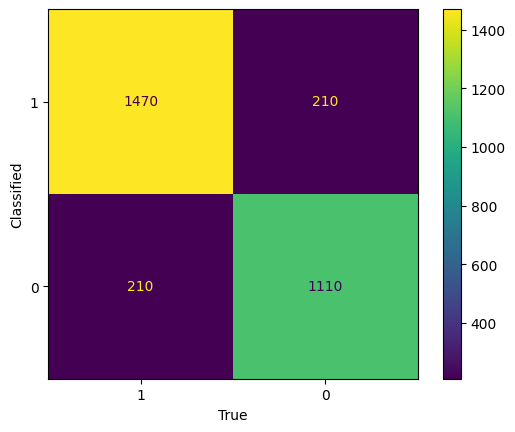

,Sensitividade,Especificidade,Acurácia
0,0.875,0.840909,0.86


In [63]:
# Matriz de confusão para cutoff = 0.5.
matriz_confusao(observado=df_fidelidade_dummies['fidelidade'], predicts=df_fidelidade_dummies['phat'], cutoff=0.50)

**Igualando critérios de especificidade e de sensitividade.**

Tentaremos estabelecer um critério que iguale a probabilidade de acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de acerto daqueles que não chegarão atrasados (especificidade).

**ATENÇÃO:** o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA FORMA o procedimento garante a maximização da acurácia do modelo!

Criação da função 'espec_sens' para a construção de um dataset com diferentes valores de cutoff, sensitividade e especificidade:

In [64]:
def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [66]:
# Até o momento, foram extraídos 3 vetores: 'sensitividade', 'especificidade' e 'cutoffs'.
# Assim, criamos um dataframe que contém os vetores mencionados.
dados_plotagem = espec_sens(observado = df_fidelidade_dummies['fidelidade'], predicts = df_fidelidade_dummies['phat'])
dados_plotagem.head()

,cutoffs,sensitividade,especificidade
0,0.00,1.0,0.000000
1,0.01,1.0,0.295455
2,0.02,1.0,0.318182
3,0.03,1.0,0.340909
4,0.04,1.0,0.386364


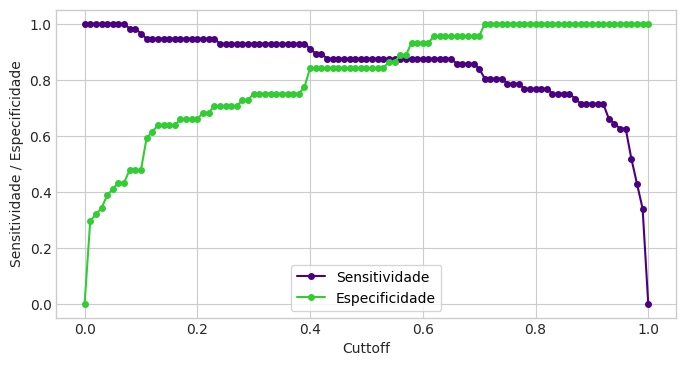

In [67]:
# Plotagem de um gráfico que mostra a variação da especificidade e da sensitividade em função do cutoff.
plt.figure(figsize=(8,4))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o', color='indigo', markersize=4)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o', color='limegreen', markersize=4)
plt.xlabel('Cuttoff', fontsize=10)
plt.ylabel('Sensitividade / Especificidade', fontsize=10)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=10)
plt.show()